# 3D U^2-Net: A 3D Universal U-Net for Multi-Domain Medical Image Segmentation:
Test things here
https://theaisummer.com/unet-architectures/

https://github.com/patrick-kidger/torchtyping


## Setup
The Medical Segmentation Decathalon data is assumed to be provided in a particular organizational structure with respect to this folder. For the sake of this exercise, I only will be using three of the provided datasets. If you have these files in the correct folder, you should receive the same (or similar) results.

```
../data/U2Net/
        Task02_Heart/
            imagesTr/
                la_003.nii.gz
                ...
                la_030.nii.gz
            imagesTs/
                la_001.nii.gz
                ...
                la_028.nii.gz
            labelsTr/
                la_003.nii.gz
                ...
                la_030.nii.gz
        
        Task04_Hippocampus/
            imagesTr/
                hippocampus_001.nii.gz
                ...
                hippocampus_394.nii.gz
            imagesTs/
                hippocampus_002.nii.gz
                ...
                hippocampus_392.nii.gz
            labelsTr/
                hippocampus_001.nii.gz
                ...
                hippocampus_394.nii.gz

        Task05_Prostate/
            imagesTr/
                prostate_00.nii.gz
                ...
                prostate_47.nii.gz
            imagesTs/
                prostate_03.nii.gz
                ...
                prostate_45.nii.gz
            labelsTr/
                prostate_00.nii.gz
                ...
                prostate_47.nii.gz


```

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import shutil
from tqdm import tqdm
import numpy as np
sys.path.append('..') # Stupid thing Python makes you do to import from a sibling directory
from gen_utils.ImgTools import ImgAug # Custom class for image generation

## Image creation class

In [2]:
from typing import List, Iterable, Tuple, Any, Union, Generator, Dict
from pathlib import Path

class UData(ImgAug):
    '''Class for data management for U^2-Net training and testing
    
    Parameters
    -------
    - path pairs for the folders containing the raw images and the labels
        [[/img_1, /label_1],[/img_2, /label_2]]
    - output directory for generated images (after patches/augmentation is applied)

    '''
    def __init__(self, img_dir: str, label_dir: str, img_out_dir: str, label_out_dir: str, prefix: str='', suffix: str='') -> None:
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_out_dir = img_out_dir
        self.label_out_dir = label_out_dir
        self.in_img_files, self.in_img_paths = self.get_files(img_dir, prefix, suffix)
        self.in_label_files, self.in_label_paths = self.get_files(label_dir, prefix, suffix)
        self.out_img_files = []
        self.out_label_files = []


    def get_files(self, file_dir:str, prefix:str, suffix:str) -> Tuple[List[str],List[str]]:
        files = []
        paths = []
        # If they have provided a list of directories (in the case of DICOM or scattered data)
        if isinstance(file_dir, list):
            for inp_dir in file_dir:
                for fil in os.listdir(inp_dir):
                    if fil.startswith(prefix) and fil.endswith(suffix):
                        paths.append(inp_dir + fil)
                        files.append(fil)

                    if not files:
                        raise FileNotFoundError('No applicable files found in input directory')
        else:
            for fil in os.listdir(file_dir):
                if fil.startswith(prefix) and fil.endswith(suffix):
                    paths.append(file_dir + fil)
                    files.append(fil)

                if not files:
                    raise FileNotFoundError('No applicable files found in input directory')

        return files, paths

    def match_files(self, img_dir: str, label_dir: str, update=False, paths=True) -> Tuple[List[Path], List[Path]]:
        # Get the files that have been generated in the output directory
        # If update is false, then just return a list of matched names, if true then
        # change the class variable values accordingly.
        hr_files = os.listdir(img_dir)
        lr_files = os.listdir(label_dir)

        # Get a set of all the files with agreement before the metadata
        if len(hr_files) > len(lr_files):
            matches = list(set(hr_files)-(set(hr_files)-set(lr_files)))
        else:
            matches = list(set(lr_files)-(set(lr_files)-set(hr_files)))

        if update:
            # If you want to save these matched files as class variables
            self.out_img_files = [Path(img_dir + _) for _ in matches]
            self.out_label_files = [Path(label_dir + _) for _ in matches]
            print('Image and Lable file locations updated')
        
        if paths:
            return [Path(img_dir + _) for _ in matches], [Path(label_dir + _ ) for _ in matches]
        
        return [], [] #lazy to make typing work out

    def load_image_pair(self, im_id: Union[int, str] ) -> Tuple[np.ndarray, np.ndarray]:
        # im_id can either be the index value or the name of the file
        
        if self.out_label_files:
            if isinstance(im_id, int):
                img_file = self.out_img_files[im_id]
                label_file = self.out_label_files[im_id]
            elif isinstance(im_id, str):
                _ = self.out_img_files.index(Path(im_id))
                img_file = self.out_img_files[_]
                label_file = self.out_label_files[_]
            else:
                TypeError("Invalid image identifier, please input a string to integer")

            img = self.load_image(img_file)
            lab = self.load_image(label_file)

            return img, lab
        else:
            raise ValueError("No paths for processed image/label files are stored in this class")


    def run(self, clear=False, save=False, contain_lab: bool=False, verbose=False) -> None:
        

        if clear:
            print('Clearing existing output directories')
            shutil.rmtree(self.img_out_dir, ignore_errors=True)
            shutil.rmtree(self.label_out_dir, ignore_errors=True)
            

        os.makedirs(self.img_out_dir, exist_ok=True)
        os.makedirs(self.label_out_dir, exist_ok=True)
        
        fnames_h = []
        fnames_l = []

        # match in_image_files and in_label_files

        #TODO: Come up with good way for match_files to handle multiple input directories
        self.in_img_paths, self.in_label_paths = self.match_files(self.img_dir, self.label_dir, update=False, paths=True)

        aug_params = {"translation":[10,10,10]}
        patch = [64, 64, 64] #Remember these have to be able to be divided down and back by 2...
        step = [20, 20, 20]

        rand_params_gen = self.gen_random_aug(aug_params)

        # for each image, label in in_img_files:
        out_img_files = []
        out_label_files = []

        for im_p, lab_p in zip(self.in_img_paths, self.in_label_paths):

            # generate a random parameter set
            rand_params = next(rand_params_gen)

            # Load images
            im = self.load_image(im_p)
            lab = self.load_image(lab_p)

            # apply image augmentations to pairs of images
            im, im_suf = self.array_translate(im, rand_params['translation'])
            lab, lab_suf = self.array_translate(lab, rand_params['translation'])

            # save as patches of size [x,y,z]
            
            if contain_lab: #Whether to only take patches which contain the label of interest

                fname = lab_p.stem
                _, b, not_lab = self.img2patches(lab, patch[:], step[:], min_nonzero= 0.1, fname=fname+lab_suf, save=[self.label_out_dir,'.nii'], verbose = False)
                out_label_files.extend(b)

                fname = im_p.stem
                _, a, not_img = self.img2patches(im, patch[:], step[:], fname=fname+im_suf, slice_select=not_lab, save=[self.img_out_dir,'.nii'], verbose = False)
                out_img_files.extend(a)

            else:
                fname = im_p.stem
                _, a, not_img = self.img2patches(im, patch[:], step[:], fname=fname+im_suf, save=[self.img_out_dir,'.nii'], verbose = False)
                out_img_files.extend(a)

                fname = lab_p.stem
                _, b, not_lab = self.img2patches(lab, patch[:], step[:], fname=fname+lab_suf, slice_select=not_img, save=[self.label_out_dir,'.nii'], verbose = False)
                out_label_files.extend(b)
            


        # update file locations for use with load_image_pair
        self.out_img_files = out_img_files
        self.out_label_files = out_label_files

## U^2-net blocks 

In [3]:
# class DoubleConv(nn.Module):
#     def __init__(self, in_ch: int, out_ch: int) -> None:
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True))

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.conv(x)
#         return x


# class InConv(nn.Module):
#     def __init__(self, in_ch: int, out_ch: int) -> None:
#         super(InConv, self).__init__()
#         self.conv = DoubleConv(in_ch, out_ch)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.conv(x)
#         return x


# class Down(nn.Module):
#     def __init__(self, in_ch: int, out_ch: int):
#         super(Down, self).__init__()
#         self.mpconv = nn.Sequential(
#             nn.MaxPool2d(2),
#             DoubleConv(in_ch, out_ch)
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.mpconv(x)
#         return x


# class Up(nn.Module):
#     def __init__(self, in_ch: int, out_ch: int, bilinear: bool=True) -> None:
#         super(Up, self).__init__()

#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         else:
#             self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

#         self.conv = DoubleConv(in_ch, out_ch)

#     def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
#         x1 = self.up(x1)

#         diffY = x2.size()[2] - x1.size()[2]
#         diffX = x2.size()[3] - x1.size()[3]

#         x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2))
#         x = torch.cat([x2, x1], dim=1)
#         x = self.conv(x)
#         return x


# class OutConv(nn.Module):
#     def __init__(self, in_ch: int, out_ch: int):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_ch, out_ch, 1)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.conv(x)
#         return x

# class Unet(nn.Module):
#     def __init__(self, in_channels: int, classes: int) -> None:
#         super(Unet, self).__init__()
#         self.n_channels = in_channels
#         self.n_classes =  classes

#         self.inc = InConv(in_channels, 64)
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         self.down3 = Down(256, 512)
#         self.down4 = Down(512, 512)
#         self.up1 = Up(1024, 256)
#         self.up2 = Up(512, 128)
#         self.up3 = Up(256, 64)
#         self.up4 = Up(128, 64)
#         self.outc = OutConv(64, classes)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         x = self.outc(x)
#         return x

## Proposed U^2-Net:
Adapter types:

`'series_adapter'` = Series Residual Adapter

`'parallel_adapter'` = Parallel Residual Adapter

`'separable_adapter'` = Residual Adapter which incorporates depthwise separable convolution (what the paper is proposing)

Model types:

`'universal'` = Model proposed in manuscript that maintains pointwise convoltion parameters across domains while having domain-specific depthwise convolution

`'independent'` = Generic U-Net model trained on single image domain

`'shared'` = Generic U-Net trained on combinaiton of all image domains(?)

- All model types seem to use some sort of [residual adapter](https://www.researchgate.net/figure/Series-vs-parallel-residual-adapters-a-typical-module-of-a-residual-network-inclusive_fig1_324055530) inspired by this [repository](https://github.com/srebuffi/residual_adapters/)


Original code key:
`nb_tasks` = The number of unique tasks that you are using the model for. So if there are two different image sets you want different models for, then `nb_tasks` = 2

`config.module` = the type of adapter you wish to use

`config.trainMode` = the model type you wish to use

`config.task_idx` = the id number associated with a particular task, this allows for selecting the weights by index for a particular task. So in `q = nn.ModuleList(...)` if you want to use the weights associated with task `i` you use `q[i](input)`



# U2-Net steps

In [34]:
def num_pool2stride_size(num_pool_per_axis):
    '''
    Calculate the stride size for the max pooling which occurs, If the num_pool_per_axis[i] for axis 2 is less than the maximum, then
    instead of a 2x2x2 pooling it will be a 2x1x2 pooling. With a step size of 1 along the axis, the pooling will not downsample it

    "The number of down-sampling operations per axis is set until the feature map size of the deepest layer reaches as small as 8"
    '''
    max_num = max(num_pool_per_axis)
    stride_size_per_pool = list()
    for i in range(max_num):
        unit = [1,2]
        stride_size_per_pool.append([unit[i<num_pool_per_axis[0]], unit[i<num_pool_per_axis[1]], unit[i<num_pool_per_axis[2]]])
    return stride_size_per_pool


class U2Net3D(nn.Module):
    def __init__(self, inChans_list: 'List[int]', num_pool_per_axis: 'List[int]', base_outChans: int=16, num_class_list: 'List[int]'=[4],
        trainMode: str='universal', module: str='separable_adapter', deep_supervision: bool=True) -> None:
        '''
        Parameters:
        inChans_list: list of input channels for the differnet image types you will be using
        num_pool_per_axis: the number of times you wish for this axis to be downsampled by 2x2 max pooling in the endocer portion.
                If you have a U-Net with depth 5 but only want to downsample the x-axis 3 times, then you would put [3,5,5]
        base_out_Chans: number of output channels for the input image before it goes through the U^2-Net
        num_class_list: 
        depth: the depth of the U-Net
        trainMode: The U-Net model type being used
        module: The type of adapter you want to use
        deep_supervision: whether to apply deep_supervision
        '''

        super(U2Net3D, self).__init__()
        #trainMode = the model type being used
        self.trainMode = trainMode
        self.module = module
        self.deep_supervision = deep_supervision

        nb_tasks = len(num_class_list)

        self.depth = max(num_pool_per_axis) + 1 # config.num_pool_per_axis firstly defined in train_xxxx.py or main.py
        stride_sizes = num_pool2stride_size(num_pool_per_axis)

        # Create a module list of the InputTransitions for each input data type
        # In other words, if you are running this model on a set of images with 2 channels and a set of
        # images with 3 channels, then self.in_tr_list = nn.ModuleList([[2x InputTran],[3x InputTran]])
        
        # TODO: In this implementaiton, they are applying a 3x3x3 instead of a 1x1x1 like they say in the paper 
        self.in_tr_list = nn.ModuleList(
            [InputTransition(inChans_list[j], base_outChans) for j in range(nb_tasks)]
        )

        outChans_list = list()
        self.down_blocks = nn.ModuleList() #register modules from regular python list.
        self.down_samps = nn.ModuleList()
        self.down_pads = list() # used to pad as padding='same' in tensorflow

        inChans = base_outChans

        # Create each level of the encoder and decoder
        for i in range(self.depth):
            outChans = base_outChans * (2**i)
            outChans_list.append(outChans)

            # Add another encoder level to the down_block module list
            self.down_blocks.append(DownBlock(nb_tasks, inChans, outChans, trainMode, module, kernel_size=3, stride=1, padding=1))

            if i != self.depth-1:
                # stride for each axis could be 1 or 2, depending on tasks. # to apply padding='SAME' as tensorflow, cal and save pad num to manually pad in forward().
                pads = list() # 6 elements for one 3-D volume. originized for last dim backward to first dim, e.g. w,w,h,h,d,d # required for F.pad.
                # pad 1 to the right end if s=2 else pad 1 to both ends (s=1). 
                for j in stride_sizes[i][::-1]:
                    if j == 2:
                        pads.extend([0,1])
                    elif j == 1:
                        pads.extend([1,1])
                self.down_pads.append(pads) 
                self.down_samps.append(DownSample(nb_tasks, outChans, outChans*2, trainMode, module, kernel_size=3, stride=tuple(stride_sizes[i]), padding=0))
                inChans = outChans*2
            else:
                inChans = outChans

        ## END OF ENCODING
        ## BEGINNING OF DECODING

        # TODO: Feel like there is a better way to do this...    
        self.up_blocks = nn.ModuleList([None] * (self.depth-1))
        self.up_samps = nn.ModuleList([None] * (self.depth-1))
        self.dSupers = nn.ModuleList()


        for i in range(self.depth-2, -1, -1):
            #Set up the upsampling which corresponds to the downsampling
            self.up_samps[i] = UnetUpsample(nb_tasks, inChans, outChans_list[i], trainMode, module, up_stride=stride_sizes[i])
            self.up_blocks[i] = UpBlock(nb_tasks, outChans_list[i]*2, outChans_list[i], trainMode, module, kernel_size=3, stride=1, padding=1)

            if self.deep_supervision and i < 3 and i > 0:
                self.dSupers.append(nn.ModuleList(
                    [DeepSupervision(outChans_list[i], num_class_list[j], up_stride=tuple(stride_sizes[i-1])) for j in range(nb_tasks)]
                ))

            inChans = outChans_list[i]

        self.out_tr_list = nn.ModuleList(
            [OutputTransition(inChans, num_class_list[j]) for j in range(nb_tasks)]
        )

    def forward(self, x:torch.Tensor, task_idx: int=0) -> torch.Tensor:
        
        deep_supervision = None #Mking this None is intentional (doesn't deactivate it)

        out = self.in_tr_list[task_idx](x)

        down_list = list()
        for i in range(self.depth):
            out = self.down_blocks[i](out, task_idx)
            # down_list.append(out)
            if i != self.depth-1:
                # print(f'shape of out is : {out.shape}')
                down_list.append(out) # will not store the deepest, so as to save memory
                out = F.pad(out,tuple(self.down_pads[i]), mode="constant", value=0)
                out = self.down_samps[i](out, task_idx)
        

        idx = 0
        for i in range(self.depth-2, -1, -1):
            if self.module in ['parallel_adapter', 'separable_adapter']:
                out, share_map, para_map = self.up_samps[i](out, task_idx)
            else:
                out = self.up_samps[i](out, task_idx)

            up_x = out
            out = torch.cat((out, down_list[i]), dim=1) #concatenate across channels?
            out = self.up_blocks[i](out, task_idx) #TODO: check what up_x used to be, because they also removed it, up_x)

            if self.deep_supervision and i < 3 and i > 0:
                deep_supervision = self.dSupers[idx][task_idx](out, deep_supervision)
                idx += 1
        
        out = self.out_tr_list[task_idx](out, deep_supervision)

        if self.module in ['parallel_adapter', 'separable_adapter']:
            return out, share_map, para_map

        else:
            return out


class DownSample(nn.Module):
    # TODO: DownSampling is not 2x2 MaxPooling, but simply a convolution with a 
    def __init__(self, nb_tasks, inChans, outChans, trainMode, module, kernel_size=3, stride=1, padding=1) -> None:
        super(DownSample, self).__init__()
        self.op1 = conv_unit(nb_tasks, inChans, outChans, trainMode, module, kernel_size=kernel_size, stride=stride, padding=padding)
        self.act1 = norm_act(outChans, meth="act")

    def forward(self, x, task_idx: int) -> torch.Tensor:
        out = self.op1(x, task_idx)
        out = self.act1(out)
        return out


class DownBlock(nn.Module):
    def __init__(self, nb_tasks, inChans, outChans, trainMode, module: str='separable_adapter', residual: bool=True, kernel_size=3, stride=1, padding=1) -> None:
        super(DownBlock, self).__init__()
        self.module = module
        self.residual = residual
        self.op1 = conv_unit(nb_tasks, inChans, outChans, trainMode, module, kernel_size=kernel_size, stride=stride, padding=padding)
        self.act1 = norm_act(outChans, meth="act")
        self.op2 = conv_unit(nb_tasks, outChans, outChans, trainMode, module, kernel_size=kernel_size, stride=stride, padding=padding)
        self.act2 = norm_act(outChans, meth="act")

    def forward(self, x, task_idx: int)-> torch.Tensor:

        # TODO: These if/else statements are redundant...

        if self.module == 'parallel_adapter' or self.module == 'separable_adapter':
            out, share_map, para_map = self.op1(x, task_idx)
        else:
            out = self.op1(x, task_idx)
        out = self.act1(out)
        if self.module == 'parallel_adapter' or self.module == 'separable_adapter':
            out, share_map, para_map = self.op2(out, task_idx)
        else:
            out = self.op2(out, task_idx)
        if self.residual: # same to ResNet
            out = self.act2(x + out)
        else:
            out = self.act2(out)

        return out

class UnetUpsample(nn.Module):
    def __init__(self, nb_tasks, inChans, outChans,trainMode, module, up_stride=(2,2,2)):
        super(UnetUpsample, self).__init__()
        self.module = module
        self.upsamples = nn.ModuleList(
            [Upsample3D(scale_factor=up_stride) for i in range(nb_tasks)]
        )
        self.op = conv_unit(nb_tasks, inChans, outChans, trainMode, module, kernel_size=3,stride=1, padding=1)
        self.act = norm_act(outChans, meth='act')

    def forward(self, x, task_idx: int):
        out = self.upsamples[task_idx](x)
        if self.module == 'parallel_adapter' or self.module == 'separable_adapter':
            out, share_map, para_map = self.op(out, task_idx)
        else:
            out = self.op(out, task_idx)
        out = self.act(out)
        if self.module == 'parallel_adapter' or self.module == 'separable_adapter':
            return out, share_map, para_map
        else:
            return out


def Upsample3D(scale_factor=(2.0,2.0,2.0)):
    '''
    task specific
    '''
    # l = tf.keras.layers.UpSampling3D(size=up_strides, data_format=DATA_FORMAT)(l) # by tkuanlun350. # no equavalent in torch?
    # scale_factor can also be a tuple. so able to custom scale_factor for each dim.
    scale_factor = [float(i) for i in scale_factor] # nn.Upsample wants float values, not integers
    upsample = nn.Upsample(scale_factor=tuple(scale_factor), mode='nearest') # ignore the warnings. Only module like upsample can be shown in my visualization. # if using ConvTranspose3d, be careful to how to pad when the down sample method used padding='SAME' strategy.
    return upsample

class UpBlock(nn.Module):
    def __init__(self, nb_tasks, inChans, outChans, trainMode, module: str='separable_adapter', kernel_size=3, stride=1, padding=1):
        super(UpBlock, self).__init__()
        self.module = module
        self.op1 = conv_unit(nb_tasks, inChans, outChans, trainMode, module, kernel_size=kernel_size, stride=stride, padding=padding)
        self.act1 = norm_act(outChans, meth="act")
        self.op2 = conv_unit(nb_tasks, outChans, outChans, trainMode, module, kernel_size=1, stride=1, padding=0)
        self.act2 = norm_act(outChans, meth="act")

    def forward(self, x, task_idx: int):
        if self.module == 'parallel_adapter' or self.module == 'separable_adapter':
            out, share_map, para_map = self.op1(x, task_idx)
        else:
            out = self.op1(x, task_idx)
        out = self.act1(out)
        if self.module == 'parallel_adapter' or self.module == 'separable_adapter':
            out, share_map, para_map = self.op2(out, task_idx)
        else:
            out = self.op2(out, task_idx)

        out = self.act2(out)

        return out


class conv_unit(nn.Module):
    '''
    Conv3D with the addition of adapter, if applicable
    '''
    def __init__(self, nb_tasks, inChans, outChans, trainMode: str, module, kernel_size: int=3, stride: int=1, padding: int=1) -> None:
        super(conv_unit, self).__init__()
        self.stride = stride
        self.trainMode = trainMode
        self.module = module

        if self.stride !=1:
            self.conv = nn.Conv3d(inChans, outChans, kernel_size=kernel_size, stride=stride, padding=padding)
        elif self.stride == 1:
            if trainMode != 'universal': # If not universal, then use generic U-Net setup
                self.conv = nn.Conv3d(inChans, outChans, kernel_size=kernel_size, stride=stride, padding=padding)
            
            elif module in ['series_adapter', 'parallel_adapter']:
                self.conv = nn.Conv3d(inChans, outChans, kernel_size=kernel_size, stride=stride, padding=padding) # padding != 0 for stride != 2 if doing padding=SAME.
                if module == 'series_adapter':
                    self.adapOps = nn.ModuleList([conv1x1(outChans, module) for i in range(nb_tasks)]) # based on https://github.com/srebuffi/residual_adapters/
                elif module == 'parallel_adapter':
                    self.adapOps = nn.ModuleList([conv1x1(inChans,module,outChans) for i in range(nb_tasks)]) 
                else:
                    pass

            elif module == 'separable_adapter':
                self.adapOps = nn.ModuleList([dwise(inChans) for i in range(nb_tasks)])
                self.pwise = pwise(inChans, outChans)

            else:
                pass

        # Effectively batch normalization
        self.op = nn.ModuleList([norm_act(outChans, meth='norm') for i in range(nb_tasks)])


    def forward(self, x, task_idx: int):
        # import ipdb; ipdb.set_trace()
        if self.stride != 1:
            out = self.conv(x)
            out = self.op[task_idx](out)
            return out
        elif self.stride == 1:
            if self.trainMode != 'universal': # independent, shared
                out = self.conv(x)
                out = self.op[task_idx](out)
            else: #universal
                if self.module in ['series_adapter', 'parallel_adapter']:
                    out = self.conv(x)
                    if self.module == 'series_adapter':
                        out = self.adapOps[task_idx](out)
                    elif self.module == 'parallel_adapter':
                        share_map = out
                        para_map = self.adapOps[task_idx](x)
                        out = out + para_map
                    else:
                        pass

                    out = self.op[task_idx](out)
                    if self.module == 'parallel_adapter':
                        return out, share_map, para_map # for visualization of feature maps
                    else:
                        return out
                elif self.module == 'separable_adapter':
                    out = self.adapOps[task_idx](x)
                    para_map = out
                    out = self.pwise(out)
                    share_map = out
                    out = self.op[task_idx](out)
                    return out, share_map, para_map
                else:
                    raise NotImplementedError(f'Adapter type: {self.module} not implemented')


class dwise(nn.Module):
    '''Depthwise convolution+normalization'''
    def __init__(self, inChans, kernel_size: int=3, stride: int=1, padding: int=1) -> None:
        super(dwise, self).__init__()
        self.conv1 = nn.Conv3d(inChans, inChans, kernel_size=kernel_size, stride=stride, padding=padding, groups=inChans) #By setting groups=inChans, the kernels are only applied to single channels
        self.op1 = norm_act(inChans,meth='both')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(x)
        out = self.op1(out)
        return out

class pwise(nn.Module):
    '''Pointwise convolution?
    '''
    def __init__(self, inChans:int, outChans:int, kernel_size: int=1, stride: int=1, padding: int=0) -> None:
        super(pwise, self).__init__()
        self.conv1 = nn.Conv3d(inChans, outChans, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x) -> torch.Tensor:
        out = self.conv1(x)
        return out




class InputTransition(nn.Module):
    '''
    task specific
    '''
    def __init__(self, inChans, base_outChans):
        super(InputTransition, self).__init__()
        self.op1 = nn.Sequential(
            nn.Conv3d(inChans, base_outChans, kernel_size=3, stride=1, padding=1),
            norm_act(base_outChans)
        )

    def forward(self, x):
        out = self.op1(x)
        return out


class OutputTransition(nn.Module):
    '''
    task specific
    '''
    def __init__(self, inChans, num_class):
        super(OutputTransition, self).__init__()
        self.conv1 = nn.Conv3d(inChans, num_class, kernel_size=1, stride=1, padding=0)
       
    def forward(self, x, deep_supervision=None):
        out = self.conv1(x)
        if deep_supervision is None:
            return out
        else:
            out = torch.add(out, deep_supervision)
            return out


class conv1x1(nn.Module):
    def __init__(self, inChans, module, outChans=None, stride=1, padding=0):
        super(conv1x1, self).__init__()
        self.module = module
        if self.module == 'series_adapter':
            self.op1 = nn.Sequential(
                norm_act(inChans,meth='norm'),
                nn.Conv3d(inChans, inChans, kernel_size=1, stride=1)
                )
        elif self.module == 'parallel_adapter':
            self.op1 = nn.Conv3d(inChans, outChans, kernel_size=1, stride=stride, padding=padding)
        else: #separable adapter
            self.op1 = nn.Conv3d(inChans, inChans, kernel_size=1, stride=1)

    def forward(self, x):
        out = self.op1(x)
        if self.module == 'series_adapter':
            out += x
        return out

def norm_act(nchan, meth='both'):
    '''The normalization activation function, or what normalization you are applying to the
    data. Either a InstanceNorm3D for meth='norm', a Leaky ReLU for meth = 'act', 
    or an LeakyReLU(InstanceNorm3D(x)) for meth='both'
     '''
    norm = nn.InstanceNorm3d(nchan, affine=True) #Calculates the mean and standard deviation across each individual channel for a single example and uses that to normalize values
    # act = nn.ReLU() # activation
    act = nn.LeakyReLU(negative_slope=1e-2)
    if meth=='norm':
        return norm
    elif meth=='act':
        return act
    else:
        return nn.Sequential(norm, act)

class DeepSupervision(nn.Module):
    '''
    task specific
    '''
    def __init__(self, inChans, num_class, up_stride=(2,2,2)):
        super(DeepSupervision, self).__init__()
        self.op1 = nn.Sequential(
            nn.Conv3d(inChans, num_class, kernel_size=1, stride=1, padding=0),
            norm_act(num_class)
        ) 
        self.op2 = Upsample3D(scale_factor=up_stride)

    def forward(self, x, deep_supervision):
        if deep_supervision is None:
            out = self.op1(x)
        else:
            out = torch.add(self.op1(x), deep_supervision)
        out = self.op2(out)
        return out


qq =  U2Net3D(inChans_list = [1], num_pool_per_axis = [3,3,3], num_class_list=[1], trainMode = 'universal') 


## Prepare Dataset

IMPORTANT: Patch size must be a power of 2, otherwise the downsampling and upsampling will not match with each other for the skip connections (see encoding and decoding for loops of the U2Net3D). For example:
```
Downsampling: 60x60 -> 30x30 -> 15x15 -> 7x7
Upsampling: 7x7 -> 14x14 -> 28x28 -> 56x56

torch.cat(15x15, 14x14) = ERROR

```


In [5]:
dat = UData('../data/U2Net/Task02_Heart/imagesTr/', '../data/U2Net/Task02_Heart/labelsTr/','../data/U2Net/Task02_Heart/patch_imgTR/','../data/U2Net/Task02_Heart/patch_labTR/')
#dat.run(clear=True, save=True, contain_lab=True)
dat.match_files('../data/U2Net/Task02_Heart/patch_imgTR/','../data/U2Net/Task02_Heart/patch_labTR/', update=True, paths=False)

Image and Lable file locations updated


([], [])

In [6]:
len(dat.out_label_files) == len(dat.out_img_files)

True

### Load Data

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, u2_class, label: int) -> None:
        self.u2_class = u2_class
        self.lab = label

    def __len__(self)->int:
        return len(self.u2_class.out_img_files)
    
    def __getitem__(self, index) -> 'tuple[torch.Tensor, torch.Tensor]':
        X, Y = self.u2_class.load_image_pair(index)

        X = torch.unsqueeze(torch.tensor(X, dtype=torch.float32),0)
        Y = torch.unsqueeze(torch.tensor(Y, dtype=torch.float32),0)

        return X,Y


### Create DataLoader
Data loader need to also provide some sort of identification based on the dataset being used if `universal` is the `self.trainMode` value

In [8]:
params = {'batch_size': 5,
        'shuffle': True,
        'num_workers': 3}

training_set = Dataset(dat, 0)
training_generator = torch.utils.data.DataLoader(training_set, **params)

## Loss functions

### Lovasz Loss Function:
Taken from https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py

In [9]:
from torch.autograd import Variable
import torch.nn.functional as F
from itertools import  filterfalse as ifilterfalse


def lovasz_softmax(probas, labels, only_present=False, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), only_present=only_present)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), only_present=only_present)
    return loss


def lovasz_softmax_flat(probas, labels, only_present=False):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    
    C = probas.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float() # foreground for class c
        if only_present and fg.sum() == 0:
            continue
        errors = (Variable(fg) - probas[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    probas = probas.view(probas.size(0), probas.size(1), -1)    # N,C,H,W => N,C,H*W
    probas = probas.transpose(1, 2) # N,C,H*W => N,H*W,C
    probas = probas.contiguous().view(-1, probas.size(2))

    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


### Focal Loss:
Commented section taken from https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    # def forward(self, input, target):
    #     if input.dim()>2:
    #         input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
    #         input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
    #         input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
    #     target = target.view(-1,1)

    #     logpt = F.log_softmax(input)
    #     logpt = logpt.gather(1,target)
    #     logpt = logpt.view(-1)
    #     pt = Variable(logpt.data.exp())

    #     if self.alpha is not None:
    #         if self.alpha.type()!=input.data.type():
    #             self.alpha = self.alpha.type_as(input.data)
    #         at = self.alpha.gather(0,target.data.view(-1))
    #         logpt = logpt * Variable(at)

    #     loss = -1 * (1-pt)**self.gamma * logpt
    #     if self.size_average: 
    #         return loss.mean()
    #     else: 
    #         return loss.sum()

    def forward(self, input, target, classes='all'):
        if classes in ['all']:
            print(f'size of input = {input.shape}')
            if input.dim()>2:
                input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
                input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
                input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
            target = target.view(-1,1).long()

            logpt = F.log_softmax(input, 1)
            logpt = logpt.gather(1,target)
            logpt = logpt.view(-1)
            pt = Variable(logpt.data.exp())

            if self.alpha is not None:
                if self.alpha.type()!=input.data.type():
                    self.alpha = self.alpha.type_as(input.data)
                at = self.alpha.gather(0,target.data.view(-1))
                logpt = logpt * Variable(at)

            loss = -1 * (1-pt)**self.gamma * logpt
            if self.size_average: return loss.mean()
            else: return loss.sum()

        elif isinstance(classes, list):
            if input.dim()>2:
                input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
                input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
                input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
            # target = target.view(-1,1).long()

            # alpha is pixel-wise weight??
            if self.alpha is not None:
                if self.alpha.type()!=input.data.type():
                    self.alpha = self.alpha.type_as(input.data)

            logpt = F.log_softmax(input, 1)

            # borrow from lovasz_loss
            C = input.size(1)
            loss = []
            class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes

            for c in class_to_sum:
                fg = (target == c).float() # foreground for class c
                class_pred = logpt[:,c]
                if (classes == 'present' and fg.sum() == 0):
                    continue
                logpt = torch.dot(class_pred, fg)
                if self.alpha is not None:
                    class_alpha = (self.alpha == c).float()
                    logpt *= class_alpha
                pt = logpt.data.exp()
                class_loss = -1 * (1-pt)**self.gamma * logpt
                loss.append(class_loss)
            loss = torch.tensor(loss).type(input.dtype)
            if self.size_average: 
                return loss.mean()
            else: 
                return loss.sum()



## Optimizer

In [38]:
lr = 0.0003
weight_decay = 5e-4

optimizer = torch.optim.Adam(qq.parameters(), lr=lr, weight_decay=weight_decay)

## Train Model

In [39]:
max_epochs = 10

focal_loss = FocalLoss(gamma=2)


for epoch in range(max_epochs):

    for inp, goal in tqdm(training_generator):
        optimizer.zero_grad()
        # print(inp.shape)
        test_output, share_map, para_map = qq(inp,0)
        print(test_output.shape) # Only care about 'out', not 'share_map' or 'para_map'
        
        output_softmax = F.softmax(test_output, dim=1)
        
        loss = lovasz_softmax(output_softmax, goal, ignore=10) + focal_loss(test_output, goal)

        print(f'Loss value of {loss}')

        loss.backward()
        optimizer.step()



  0%|          | 0/62 [00:00<?, ?it/s]

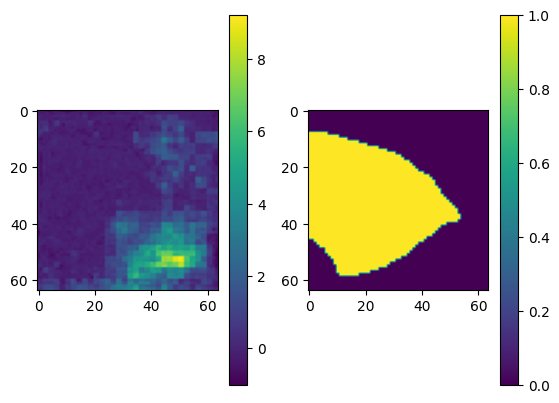

In [33]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)

loc = 40

a = axs[0].imshow(test_output[0,0,loc,:,:].detach().numpy())
b = axs[1].imshow(goal[0,0,loc,:,:].detach().numpy())
plt.colorbar(a, ax=axs[0])
plt.colorbar(b, ax=axs[1])

## Test Model